In [0]:
import matplotlib
import matplotlib.pyplot as plt

## Знакомство с тензорами и автоматическое дифференцирование

In [0]:
import torch

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
torch.manual_seed(42)

x = torch.rand(3, 2)
print(x)
print(x.shape)
print()

y = torch.rand(3, 2)
x = x + y
print(x)

tensor([[0.8823, 0.9150],
        [0.3829, 0.9593],
        [0.3904, 0.6009]])
torch.Size([3, 2])

tensor([[1.1388, 1.7086],
        [1.3236, 1.0925],
        [1.3250, 1.1945]])


In [4]:
import numpy as np

x = np.ones((3, 2), dtype=np.float32)
z = torch.from_numpy(x)

print(x)
print(z)

[[1. 1.]
 [1. 1.]
 [1. 1.]]
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


In [5]:
x = torch.ones(3,2)
z = x.numpy()

print(x)
print(z)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
[[1. 1.]
 [1. 1.]
 [1. 1.]]


$$F({\bf x})=\left|\left|{\bf x}\right|\right|^2$$
$$\frac{\partial F}{\partial x_i} = ?$$

In [6]:
torch.manual_seed(42)

x = torch.rand(10, requires_grad=True)
print(x)
print()

norm = torch.dot(x, x)
print(norm)
print()

norm.backward()
print(x.grad)

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936, 0.9408,
        0.1332], requires_grad=True)

tensor(4.7945, grad_fn=<DotBackward>)

tensor([1.7645, 1.8300, 0.7657, 1.9186, 0.7809, 1.2018, 0.5131, 1.5873, 1.8815,
        0.2664])


## Классификаторы. Сети прямого распространения

In [0]:
import numpy as np
import pandas as pd

names = ["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
data = pd.read_csv('/content/drive/My Drive/2020-hw3-mindelly-master/magic04.csv', names=names)

x = np.asarray(data.iloc[:, :-1])
y = np.asarray(data.iloc[:, [-1]])
y = (y == 'g').astype(np.float32)

In [0]:
print(y)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [0]:
import torch.utils.data

X = torch.from_numpy(x.astype(np.float32))
Y = torch.from_numpy(y.astype(np.float32))

dataset = torch.utils.data.TensorDataset(X, Y)
dataset_len = len(dataset)
train_dataset_len = int(0.8*dataset_len)
test_dataset_len = dataset_len - train_dataset_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_dataset_len, test_dataset_len])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=5)

In [12]:

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

INPUT_DIM  = x.shape[1]
HIDDEN_DIM = 20
OUTPUT_DIM = y.shape[1]

model = torch.nn.Sequential(
    torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
    torch.nn.Sigmoid(),
    torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
    torch.nn.Sigmoid(),
)

loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 25
train_loss_hist = []
test_loss_hist = []
for e in tqdm(range(epochs)):
    for i, batch in enumerate(train_loader):
        features, labels = batch
        y_pred = model(features)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss_hist.append(loss)
    with torch.no_grad():
        count = 0
        total_loss = 0
        for i, batch in enumerate(test_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            count += 1
            total_loss += loss
        test_loss_hist.append(total_loss/count)

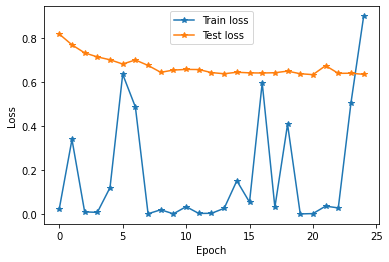

In [13]:
train_loss_hist = np.asarray(train_loss_hist)
test_loss_hist = np.asarray(test_loss_hist)
plt.plot(train_loss_hist, '-*', label='Train loss')
plt.plot(test_loss_hist, '-*', label='Test loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [14]:
confusion_matrix = torch.zeros((2,2))
true_and_scores = []
with torch.no_grad():
    for batch in test_loader:
        features, labels = batch
        
        scores = model(features)
        y_pred = (scores > 0.5)
        for t, p in zip(labels.view(-1), y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))
        
true_and_scores = np.vstack(true_and_scores)

tn, fp, fn, tp = confusion_matrix.view(-1)
accuracy  = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall    = tp / (tp + fn)
specificity = tn / (tn + fp)
baccuracy = 0.5 * (specificity + recall)
    
print("Accuracy                  = {:.4f}".format(accuracy))
print("Ballanced accuracy        = {:.4f}".format(baccuracy))
print("Precision (PPV)           = {:.4f}".format(precision))
print("Recall (sensitivity, TPR) = {:.4f}".format(recall))

Accuracy                  = 0.8210
Ballanced accuracy        = 0.7804
Precision (PPV)           = 0.8262
Recall (sensitivity, TPR) = 0.9169


AUC                       = 0.8771


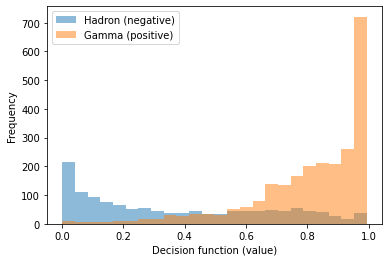

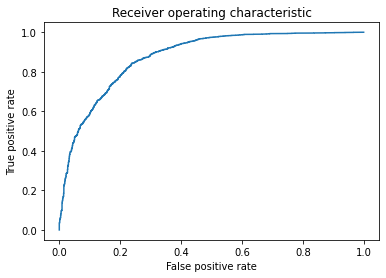

In [15]:
import sklearn.metrics

y_true = true_and_scores[:,0]
scores = true_and_scores[:,1]

min_score, max_score = np.min(scores), np.max(scores)
bins = np.linspace(min_score, max_score, 25)
plt.figure()
plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
plt.xlabel("Decision function (value)")
plt.ylabel("Frequency")
plt.legend()

fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
auc = sklearn.metrics.roc_auc_score(y_true, scores)
plt.figure()
plt.plot(fpr, tpr)
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
print("AUC                       = {:.4f}".format(auc))

**Задание 3a.1** Это задание на *бонусные балы*. Вам нужно использовать готовый код классификатора выше, чтобы улучшить качество классификатора в смысле *AUC*.

Попробуйте исследовать как результат меняется в зависимости от числа скрытых нейронов, вида функции активации, применяемого для обучения оптимизатора. Помогает ли добавление дополнительного скрытого слоя? Поможет ли применение анализа главных компонент для входных данных перед обучением нейросети?

*Бонусные баллы* положены за лучшие пять решений среди всей группы.

In [0]:
import sklearn.metrics

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

def better_result(HIDDEN_DIM, model):
    torch.manual_seed(42)

    INPUT_DIM  = x.shape[1]
    #HIDDEN_DIM = 40
    OUTPUT_DIM = y.shape[1]

    """model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.Sigmoid(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.Sigmoid(),
    )"""

    loss_fn = torch.nn.MSELoss(reduction='sum')

    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 25
    train_loss_hist = []
    test_loss_hist = []
    for e in tqdm(range(epochs)):
        for i, batch in enumerate(train_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_hist.append(loss)
        with torch.no_grad():
            count = 0
            total_loss = 0
            for i, batch in enumerate(test_loader):
                features, labels = batch
                y_pred = model(features)
                loss = loss_fn(y_pred, labels)
                count += 1
                total_loss += loss
            test_loss_hist.append(total_loss/count)

    train_loss_hist = np.asarray(train_loss_hist)
    test_loss_hist = np.asarray(test_loss_hist)
    plt.plot(train_loss_hist, '-*', label='Train loss')
    plt.plot(test_loss_hist, '-*', label='Test loss')
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()


    confusion_matrix = torch.zeros((2,2))
    true_and_scores = []
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch

            scores = model(features)
            y_pred = (scores > 0.5)
            for t, p in zip(labels.view(-1), y_pred.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

            true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))

    true_and_scores = np.vstack(true_and_scores)

    tn, fp, fn, tp = confusion_matrix.view(-1)
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))


    y_true = true_and_scores[:,0]
    scores = true_and_scores[:,1]

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
    auc = sklearn.metrics.roc_auc_score(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))

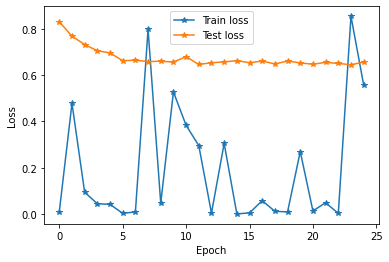

Accuracy                  = 0.8134
Ballanced accuracy        = 0.7792
Precision (PPV)           = 0.8309
Recall (sensitivity, TPR) = 0.8942
AUC                       = 0.8717


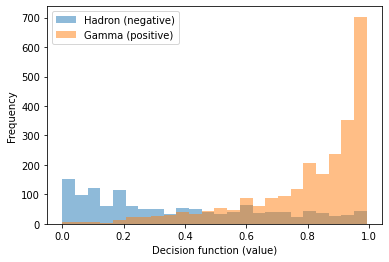

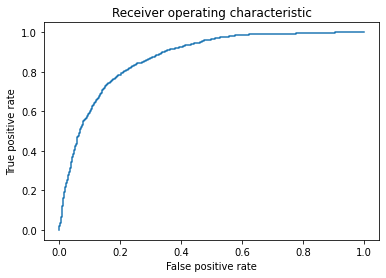

In [19]:
model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.Sigmoid(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.Sigmoid())
better_result(40, model)



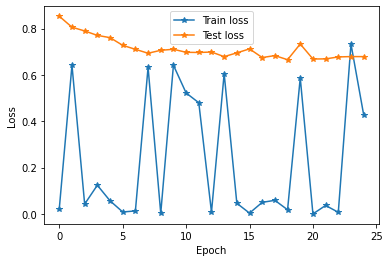

Accuracy                  = 0.8097
Ballanced accuracy        = 0.7551
Precision (PPV)           = 0.8017
Recall (sensitivity, TPR) = 0.9388
AUC                       = 0.8614


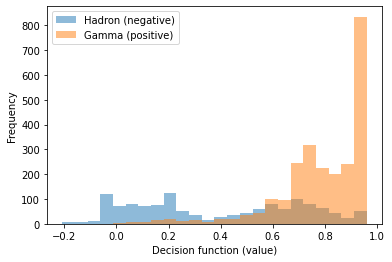

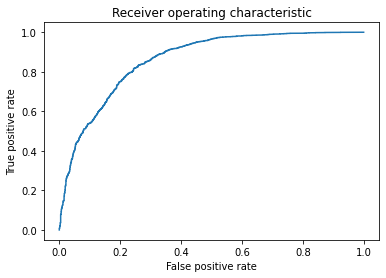

In [20]:
#Tanh
model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.Tanh(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.Tanh())
better_result(40, model)

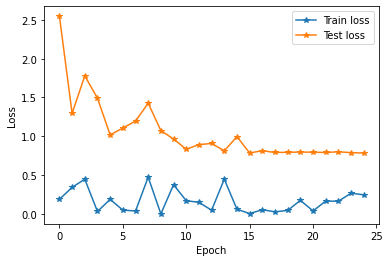

Accuracy                  = 0.7781
Ballanced accuracy        = 0.7186
Precision (PPV)           = 0.7788
Recall (sensitivity, TPR) = 0.9189
AUC                       = 0.8276


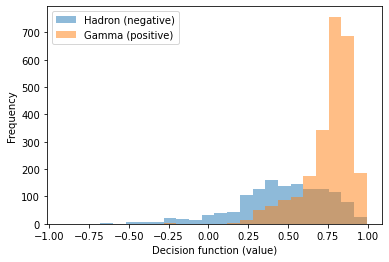

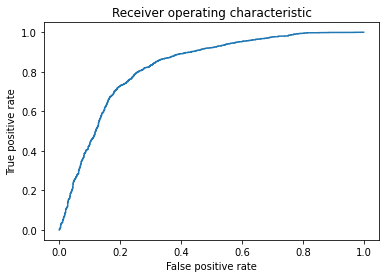

In [22]:
#Identity function
model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.Identity(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.Identity())
better_result(40, model)

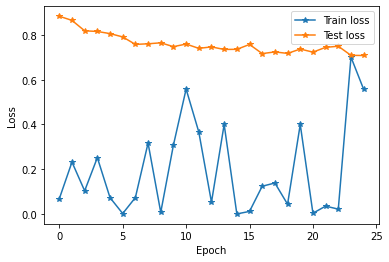

Accuracy                  = 0.7992
Ballanced accuracy        = 0.7551
Precision (PPV)           = 0.8091
Recall (sensitivity, TPR) = 0.9035
AUC                       = 0.8547


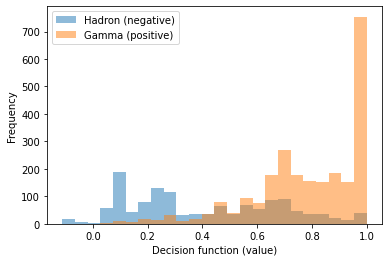

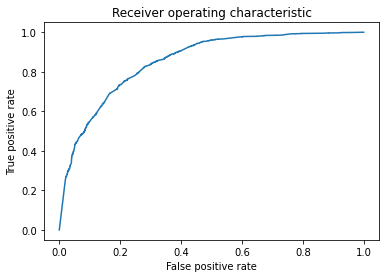

In [24]:
#HardTanh function
model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.Hardtanh(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.Hardtanh())
better_result(40, model)

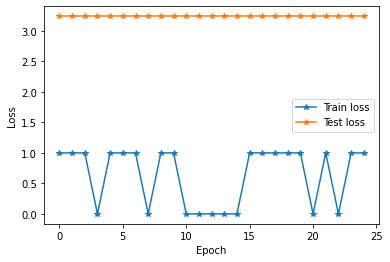

Accuracy                  = 0.3515
Ballanced accuracy        = 0.5000
Precision (PPV)           = nan
Recall (sensitivity, TPR) = 0.0000
AUC                       = 0.5000


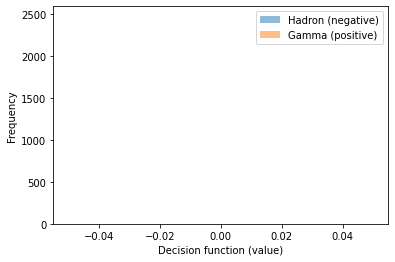

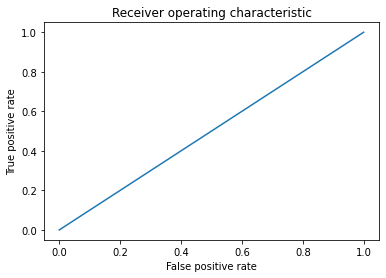

In [25]:
#ReLU function
model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.ReLU(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.ReLU())
better_result(40, model)

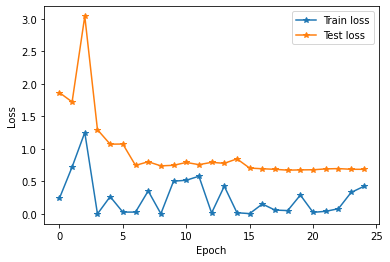

Accuracy                  = 0.8254
Ballanced accuracy        = 0.7986
Precision (PPV)           = 0.8490
Recall (sensitivity, TPR) = 0.8889
AUC                       = 0.8852


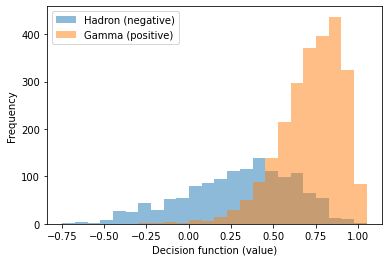

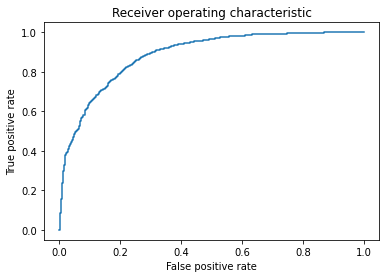

In [26]:
#eLU
model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.ELU(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.ELU())
better_result(40, model)


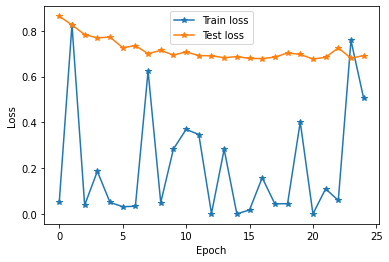

Accuracy                  = 0.8115
Ballanced accuracy        = 0.7747
Precision (PPV)           = 0.8260
Recall (sensitivity, TPR) = 0.8987
AUC                       = 0.8444


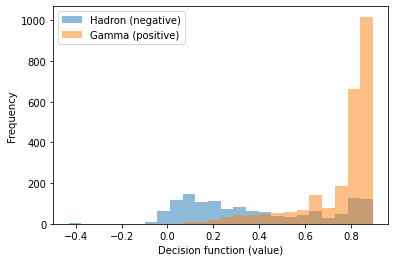

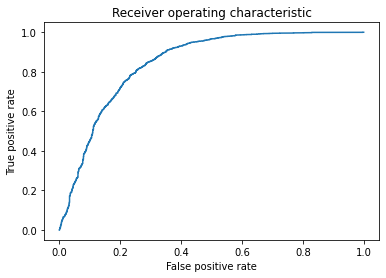

In [27]:
#SIGN function
model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.Softsign(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.Softsign())
better_result(40, model)

Самые лучший показатель auc появляется при использовании функции активации ELU.

In [0]:
HIDDEN_DIM1 = 70
model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.ELU(),
      torch.nn.Linear(HIDDEN_DIM, HIDDEN_DIM1),
      torch.nn.ELU(),
      torch.nn.Linear(HIDDEN_DIM1, OUTPUT_DIM),
      torch.nn.ELU())


In [0]:
def better_result(HIDDEN_DIM, HIDDEN_DIM1, model):
    torch.manual_seed(42)

    INPUT_DIM  = x.shape[1]
    OUTPUT_DIM = y.shape[1]

    loss_fn = torch.nn.MSELoss(reduction='sum')

    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 25
    train_loss_hist = []
    test_loss_hist = []
    for e in tqdm(range(epochs)):
        for i, batch in enumerate(train_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_hist.append(loss)
        with torch.no_grad():
            count = 0
            total_loss = 0
            for i, batch in enumerate(test_loader):
                features, labels = batch
                y_pred = model(features)
                loss = loss_fn(y_pred, labels)
                count += 1
                total_loss += loss
            test_loss_hist.append(total_loss/count)

    train_loss_hist = np.asarray(train_loss_hist)
    test_loss_hist = np.asarray(test_loss_hist)
    plt.plot(train_loss_hist, '-*', label='Train loss')
    plt.plot(test_loss_hist, '-*', label='Test loss')
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()


    confusion_matrix = torch.zeros((2,2))
    true_and_scores = []
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch

            scores = model(features)
            y_pred = (scores > 0.5)
            for t, p in zip(labels.view(-1), y_pred.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

            true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))

    true_and_scores = np.vstack(true_and_scores)

    tn, fp, fn, tp = confusion_matrix.view(-1)
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))


    y_true = true_and_scores[:,0]
    scores = true_and_scores[:,1]

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
    auc = sklearn.metrics.roc_auc_score(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))



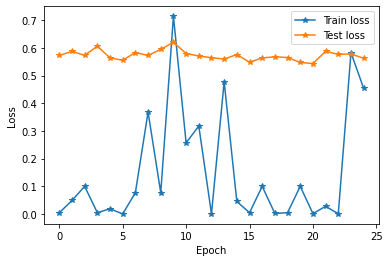

Accuracy                  = 0.8525
Ballanced accuracy        = 0.8245
Precision (PPV)           = 0.8626
Recall (sensitivity, TPR) = 0.9189
AUC                       = 0.9039


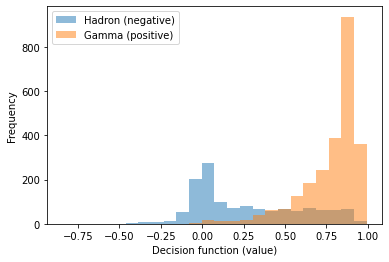

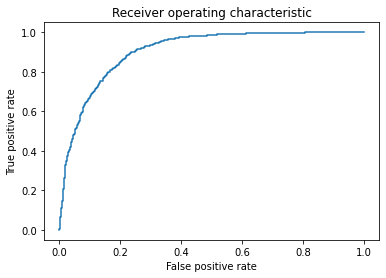

In [33]:
better_result(80, 40, model)

**Задание 3a.2** Перед вами набор данных рукописных цифр MNIST (черно-белые изображения, размером 28x28 пикселей каждое). Задача состоит в том, чтобы сделать автоэнкодер на базе свёрточной нейронной сети. Размерность пространства закодированного представления (латентный слой) должна быть 8. Подберите параметры свёрточных слоев.

*Бонусные баллы* положены за автоэнкодер с наименьшим среднеквадратичным отклонением `torch.nn.MSELoss` на тестовых данных и размерностью закодированного представления 8. Попробуйте добавить новые свёрточные слои или менять конфигурацию существующих, или вид функций активации.

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


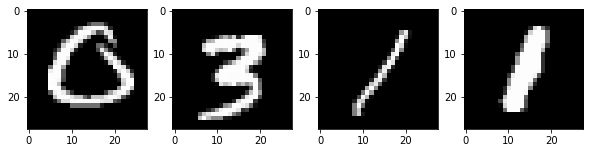

In [0]:
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(43)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.0, 1.0)
])

train_dataset = torchvision.datasets.MNIST(root="./mnist", download=True, transform=transform, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root="./mnist", download=True, transform=transform, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')

plt.show()

In [0]:
torch.manual_seed(43)

INPUT_CH  = images.shape[1]
HIDDEN1_CH = 128
HIDDEN2_CH = 64
LATENT_DIM = 8

class CNNAutoEncoder(torch.nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(INPUT_CH, HIDDEN1_CH, 3, stride=2),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(HIDDEN1_CH, HIDDEN2_CH, 3, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(HIDDEN2_CH, LATENT_DIM, 6, bias=False),
            torch.nn.Sigmoid(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.LayerNorm((LATENT_DIM, 1, 1)),
            
            torch.nn.ConvTranspose2d(LATENT_DIM, HIDDEN2_CH, 6, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN2_CH, HIDDEN2_CH, 3, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN2_CH, HIDDEN1_CH, 4, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN1_CH, INPUT_CH, 1, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

model = CNNAutoEncoder()

loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 5
train_loss_hist = []
test_loss_hist = []
for e in range(epochs):
    for i, batch in tqdm(enumerate(train_loader)):
        images, labels = batch
        _, decoded = model(images)
        loss = loss_fn(decoded, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    train_loss_hist.append(loss)
    with torch.no_grad():
        count = 0
        total_loss = 0
        for i, batch in enumerate(test_loader):
            images, labels = batch
            _, decoded = model(images)
            loss = loss_fn(decoded, images)
            count += 1
            total_loss += loss
        test_loss_hist.append(total_loss/count)

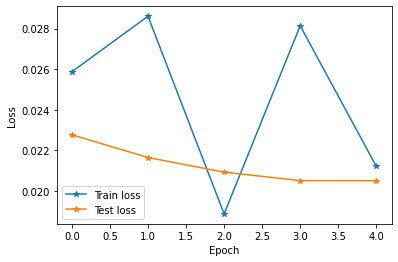

In [0]:
train_loss_hist = np.asarray(train_loss_hist)
test_loss_hist = np.asarray(test_loss_hist)
plt.plot(train_loss_hist, '-*', label='Train loss')
plt.plot(test_loss_hist, '-*', label='Test loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [0]:
count = 0
total_loss = 0
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images, labels = batch
        _, decoded = model(images)
        loss = loss_fn(decoded, images)
        
        count += 1
        total_loss += loss

    print("Average loss = {:.4f}".format(total_loss/count))

Average loss = 0.0205


**Задание 3a.3** Используя обученную модель автоэнкодера нарисуйте для четырех изображений тестового набора данных: само изображение, его закодированное представление в виде гистограммы, а так же раскодированное изображение. Ниже приведена заготовка кода рисующего изображения.

torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])


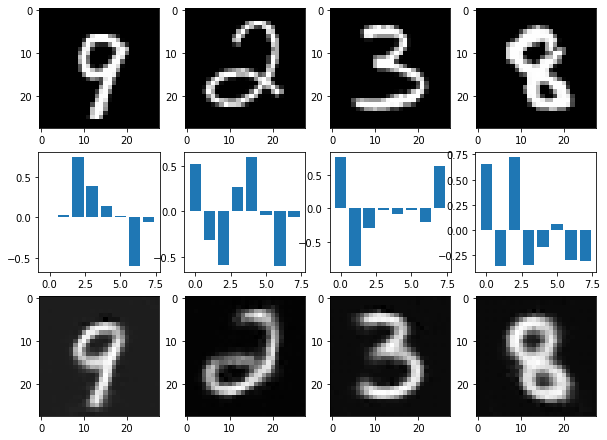

In [0]:
images, _ = iter(test_loader).next()

plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    inp = images # ???
    plt.imshow(inp[i].reshape(28,28), cmap='gray')
    ax = plt.subplot(3, n_col, i + 1 + n_col)
    encoded, decoded = model(images) # ???
    print(encoded.shape)
    plt.bar(np.arange(encoded[i].shape[0]), encoded[i].detach())
    ax = plt.subplot(3, n_col, i + 1 + n_col * 2)
    plt.imshow(decoded[i].detach().numpy().reshape(28,28), cmap='gray')

plt.show()

**Задание 3a.4** Проделайте задание **3a.3**, но теперь на вход автоэнкодера следует подать изображения с добавленным к ним равномерно распределенным шумом амплитуды `noise_level`. После добавления шума, входные данные возможно придётся перенормировать, так как нейросеть ожидает, что в каждом пикселе содержится число от $0.0$ до $1.0$. Придумайте как это сделать.

torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])


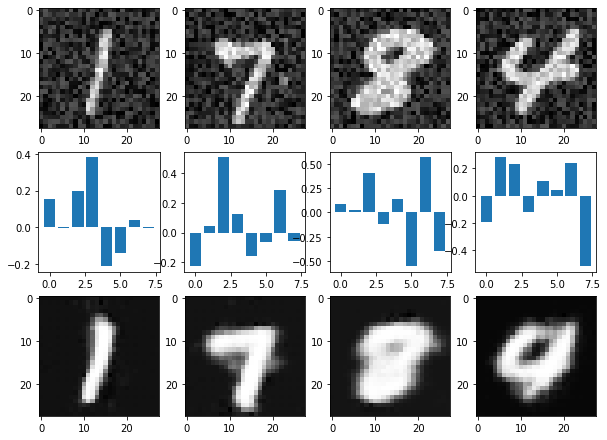

In [0]:
images, _ = iter(test_loader).next()
noise_level = 0.5 #уровень шума
images = (images + torch.rand(4, 1, 28, 28) * noise_level) / (1 + noise_level) 


plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    inp = images
    plt.imshow(inp[i].reshape(28,28), cmap='gray')
    ax = plt.subplot(3, n_col, i + 1 + n_col)
    encoded, decoded = model(images) # ???
    print(encoded.shape)
    plt.bar(np.arange(encoded[i].shape[0]), encoded[i].detach())
    ax = plt.subplot(3, n_col, i + 1 + n_col * 2)
    plt.imshow(decoded[i].detach().numpy().reshape(28,28), cmap='gray')

plt.show()

**Задание 3a.5** В задании **3a.4** вы должны были обнаружить, что автоэнкодер можно использовать для удаления шума из данных. В векторе `noise_levels` задана сетка амплитуды шумов для входных данных. Предлагается построить график зависимости от амплитуды шума для среднеквадратичного отклонения `torch.nn.MSELoss` между выходом автоэнкодера и незашумленным (истинным) входным изображением. Используйте полный тестовый датасет для вычисления значений. При шуме нулевой амплитуды (нет шума) среднеквадратичное отклонение будет определяться самой моделью. При постепенном добавлении шума он будет мешать нейросети распознать исходное изображение абсолютно корректно.

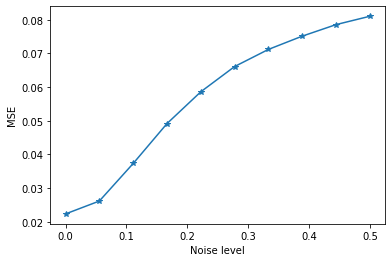

In [0]:
noise_levels = np.linspace(0.0, 0.5, 10)
noise = []

for noise_level in noise_levels:
    count = 0
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            images, labels = batch
            noised = (images + torch.randn(images.shape) * noise_level) / (1.0 + noise_level)
            _, decoded = model(noised)
            loss = loss_fn(decoded, images)
        
            count += 1
            total_loss += loss
        noise.append([total_loss/count])
        
plt.plot(noise_levels, np.asarray(noise), "-*")
plt.ylabel("MSE")
plt.xlabel("Noise level")
plt.show()

**Задание 3a.6** Аналогично заданию **3a.3** сгенерируйте и подайте на вход декодера случайные данные, совпадающие по своим статистическим свойствам с содержимым латентного слоя. Нарисуйте сгенерированные декодером изображения.

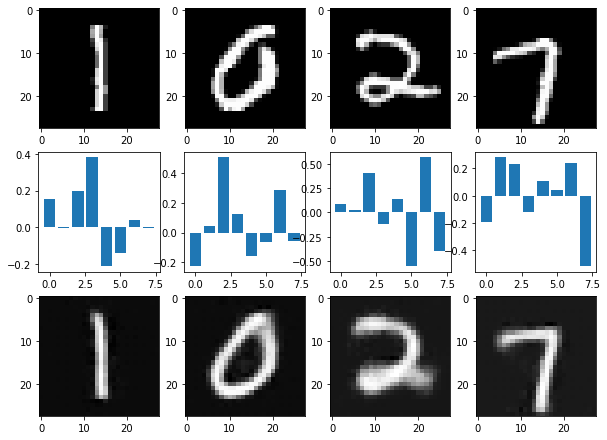

In [0]:
plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    inp = images
    plt.imshow(inp[i].reshape(28, 28), cmap='gray')
    ax = plt.subplot(3, n_col, i + 1 + n_col)
    ecnoded, decoded = model(images)
    plt.bar(np.arange(encoded[i].shape[0]), encoded[i].detach())
    ax = plt.subplot(3, n_col, i + 1 + n_col * 2)
    plt.imshow(decoded[i].detach().numpy().reshape(28, 28), cmap='gray')
plt.show()

**Задание 3a.7** Перед вами набор данных изображений STL10. Он состоит из цветных фотографий размером 96x96, отнесённых к одному из десяти различных классов: аэроплан, птичка, автомобиль, котик, олень, собака, лошадь, обезьяна, корабль, грузовик. Задача состоит в том, чтобы построить классификатор используя свёрточные нейронные сети, используя "transfer learning". Библиотека `torchvision` содержит в себе уже обученную глубокую свёрточную нейросеть AlexNet (`torchvision.models.alexnet`), эта сеть позволяет классифицировать фотографии на 1000 различных классов (набор данных ImageNet) и состоит из двух частей:
 * нескольких свёрточных слоев в начале сети
 * нескольких полносвязных слоев в конце сети
 
Можно считать, что первая половина сети генерирует некоторый набор универсальных признаков, на основе которого можно классифицировать фотографии из других наборов данных. Вам предлагается заменить часть нейросети состоящей из полносвязных слоев для решения задачи классификации STL10. Свёрточные слои обучать не следует, т.е. их веса остаются фиксированными и известными.

В качестве функции потерь для классификатора убодно использовать `torch.nn.CrossEntropyLoss`.

Используйте готовую функцию `sklearn.metrics.confusion_matrix` и класс `sklearn.metrics.ConfusionMatrixDisplay` чтобы вычислить и нарисовать матрицу ошибок для тестового набора данных. Используйте готовую функцию `sklearn.metrics.classification_report`, чтобы подсчитать точность (precision) и полноту (recall) для каждого из целевых классов.

*Бонусные балы* полагаются за лучшее среди всей группы значение функции потерь на тестовом наборе данных.

Extracting ./stl10/stl10_binary.tar.gz to ./stl10
Files already downloaded and verified
['airplane' 'truck' 'car' 'monkey']


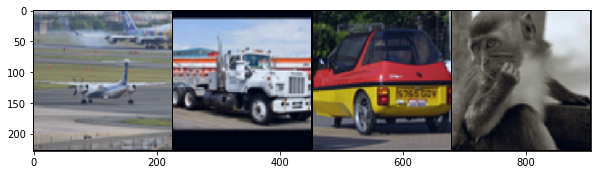

In [0]:
import torch
import torchvision.models
import torchvision.datasets
import torchvision.transforms

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10,8))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

train_dataset = torchvision.datasets.STL10("./stl10", split='train', transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = torchvision.datasets.STL10("./stl10", split='test', transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

class_names = np.array(["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"])

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(class_names[labels.numpy()])
show(torchvision.utils.make_grid(images, normalize=True))

In [0]:
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [0]:
torch.manual_seed(43)

HIDDEN_DIM = 512
class ClassifierModel(torch.nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = torch.nn.Sequential(
            nn.Dropout(),
            # тут должна была быть полносвязная сеть, но она пропала.
            # известно, что на входе должно быть 256 * 6 * 6 значений,
            # а на выходе вектор из 10 признаков

    torch.nn.Linear(256 * 6 * 6, HIDDEN_DIM),
    torch.nn.Sigmoid(),
    torch.nn.Linear(HIDDEN_DIM, 10),
    torch.nn.Sigmoid(),
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = ClassifierModel()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

epochs = 5
for e in range(epochs):
    for i, batch in tqdm(enumerate(train_loader)):
        images, labels = batch
        output = model(images)
        loss = loss_fn(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print("epoch = {} batch = {} loss = {}".format(e, i, loss))

epoch = 0 batch = 0 loss = 2.2362146377563477
epoch = 0 batch = 100 loss = 2.207078456878662
epoch = 0 batch = 200 loss = 2.0739078521728516
epoch = 0 batch = 300 loss = 2.1621408462524414
epoch = 0 batch = 400 loss = 2.1311306953430176
epoch = 0 batch = 500 loss = 1.932016134262085
epoch = 0 batch = 600 loss = 1.9359805583953857
epoch = 0 batch = 700 loss = 1.8681992292404175
epoch = 0 batch = 800 loss = 1.9329299926757812
epoch = 0 batch = 900 loss = 1.9582171440124512
epoch = 0 batch = 1000 loss = 1.8884614706039429
epoch = 0 batch = 1100 loss = 1.8027775287628174
epoch = 0 batch = 1200 loss = 1.8216817378997803



epoch = 1 batch = 0 loss = 1.7367790937423706
epoch = 1 batch = 100 loss = 1.8385335206985474
epoch = 1 batch = 200 loss = 1.9576364755630493
epoch = 1 batch = 300 loss = 1.8050580024719238
epoch = 1 batch = 400 loss = 1.815409541130066
epoch = 1 batch = 500 loss = 1.7516790628433228
epoch = 1 batch = 600 loss = 1.7765276432037354
epoch = 1 batch = 700 loss = 1.6601667404174805
epoch = 1 batch = 800 loss = 1.8796718120574951
epoch = 1 batch = 900 loss = 1.672224521636963
epoch = 1 batch = 1000 loss = 1.7739765644073486
epoch = 1 batch = 1100 loss = 1.6459896564483643
epoch = 1 batch = 1200 loss = 1.7753517627716064



epoch = 2 batch = 0 loss = 1.7841848134994507
epoch = 2 batch = 100 loss = 1.643442988395691
epoch = 2 batch = 200 loss = 1.843448519706726
epoch = 2 batch = 300 loss = 1.7173000574111938
epoch = 2 batch = 400 loss = 1.6002197265625
epoch = 2 batch = 500 loss = 1.808772325515747
epoch = 2 batch = 600 loss = 1.6301156282424927
epoch = 2 batch = 700 loss = 1.648614525794983
epoch = 2 batch = 800 loss = 1.5981614589691162
epoch = 2 batch = 900 loss = 1.5870530605316162
epoch = 2 batch = 1000 loss = 1.5930873155593872
epoch = 2 batch = 1100 loss = 1.6044056415557861
epoch = 2 batch = 1200 loss = 1.542939305305481



epoch = 3 batch = 0 loss = 1.73566734790802
epoch = 3 batch = 100 loss = 1.727310061454773
epoch = 3 batch = 200 loss = 1.6466476917266846
epoch = 3 batch = 300 loss = 1.665097951889038
epoch = 3 batch = 400 loss = 1.5943979024887085
epoch = 3 batch = 500 loss = 1.6271106004714966
epoch = 3 batch = 600 loss = 1.6792478561401367
epoch = 3 batch = 700 loss = 1.5606478452682495
epoch = 3 batch = 800 loss = 1.6861798763275146
epoch = 3 batch = 900 loss = 1.5770626068115234
epoch = 3 batch = 1000 loss = 1.5667049884796143
epoch = 3 batch = 1100 loss = 1.5749591588974
epoch = 3 batch = 1200 loss = 1.5954335927963257



epoch = 4 batch = 0 loss = 1.6534119844436646
epoch = 4 batch = 100 loss = 1.5477498769760132
epoch = 4 batch = 200 loss = 1.5988609790802002
epoch = 4 batch = 300 loss = 1.5583873987197876
epoch = 4 batch = 400 loss = 1.5369561910629272
epoch = 4 batch = 500 loss = 1.544251799583435
epoch = 4 batch = 600 loss = 1.5315284729003906
epoch = 4 batch = 700 loss = 1.5826060771942139
epoch = 4 batch = 800 loss = 1.5963122844696045
epoch = 4 batch = 900 loss = 1.6248283386230469
epoch = 4 batch = 1000 loss = 1.5706521272659302
epoch = 4 batch = 1100 loss = 1.7295782566070557
epoch = 4 batch = 1200 loss = 1.5481730699539185



In [0]:
count = 0
total_loss = 0
true_and_pred = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images, labels = batch
        output = model(images)
        loss = loss_fn(output, labels)
        
        count += 1
        total_loss += loss
        
        y_pred = torch.max(output, axis=1).indices
        true_and_pred.append(np.vstack([labels.numpy(), y_pred.numpy()]))

true_and_pred = np.hstack(true_and_pred)

print("Average loss = {:.4f}".format(total_loss/count))

Average loss = 1.6400


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00         0
        bird       0.00      0.00      0.00         0
         car       0.00      0.00      0.00         0
         cat       1.00      0.50      0.67         2
        deer       0.00      0.00      0.00         0
         dog       0.00      0.00      0.00         0
       horse       1.00      1.00      1.00         1
      monkey       0.00      0.00      0.00         1
        ship       0.00      0.00      0.00         0
       truck       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50         4
   macro avg       0.20      0.15      0.17         4
weighted avg       0.75      0.50      0.58         4

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


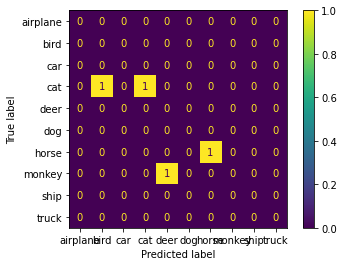

In [0]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn.metrics import ConfusionMatrixDisplay 
 
data_true = class_names[labels.numpy()] 
data_test = class_names[torch.max(model(images), axis = 1).indices] 
print(classification_report(data_true, data_test, labels=class_names)) 
 
cm = confusion_matrix(data_true, data_test, labels=class_names) # confusion_matrix 
print(cm) 
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names) 
_ = cmd.plot()